In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms
from contourlet_cnn import ContourletCNN
from torch.utils.data import Dataset

## Custom dataset loader

In [2]:
# Custom dataset class
class ListImages(Dataset):
    def __init__(self, img_paths, transforms=None, target_transform=None):
        self.img_paths = img_paths
        self.img_labels = np.zeros(len(self.img_paths))
        self.transforms = transforms
        self.target_transform = target_transform
           
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        # Load label
        label = self.img_labels[idx]
        # Transform image or label
        if self.transforms:
            for transform in self.transforms:
                image = transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Initialize a Contourlet-CNN model

In [3]:
# Device settings
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") 

# Initialize an instance of C-CNN model
model = ContourletCNN(input_dim=(3, 224, 224), n_levs=[0, 3, 3, 3], num_classes=3, variant="SSF", spec_type="all").to(device)
print(model)

ContourletCNN(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(88, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(88, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(152, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_7): Conv2d(268, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_8): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (fc_1): Linear(in_features=128, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2216, out_features=3, bias=True)
)


## Load image and perform Contourlet Decomposition
Contourlet Decomposition is achieved by applying Pyramidal directional filter bank decomposition (pdfbdec).

In [4]:
# Load a single image
test_loader = torch.utils.data.DataLoader(
    ListImages([
        "./images/Lenna.png", 
    ], transforms=[
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
    ]), 
    batch_size=2, shuffle=False)

with torch.no_grad():
    for data, target in test_loader:
        x = data.to(device)
        # Here, we call the private method, __pdfbdec() from C-CNN on the image
        y, _ = model._ContourletCNN__pdfbdec(x=x, method="resize")

## Visualize the output

(1, 24, 112, 112)


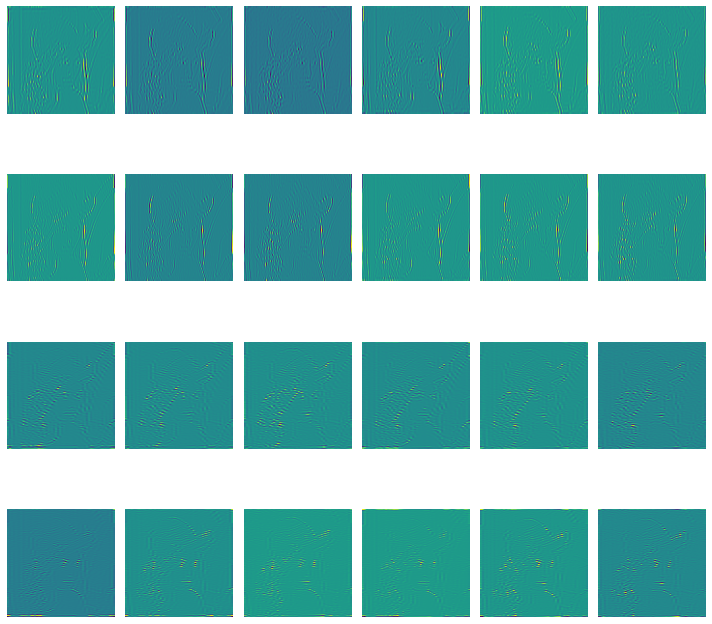

(1, 24, 56, 56)


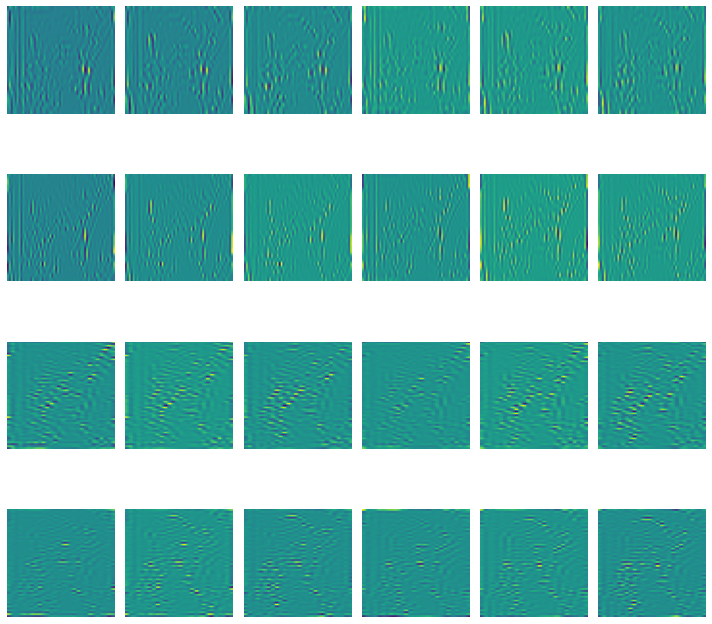

(1, 24, 28, 28)


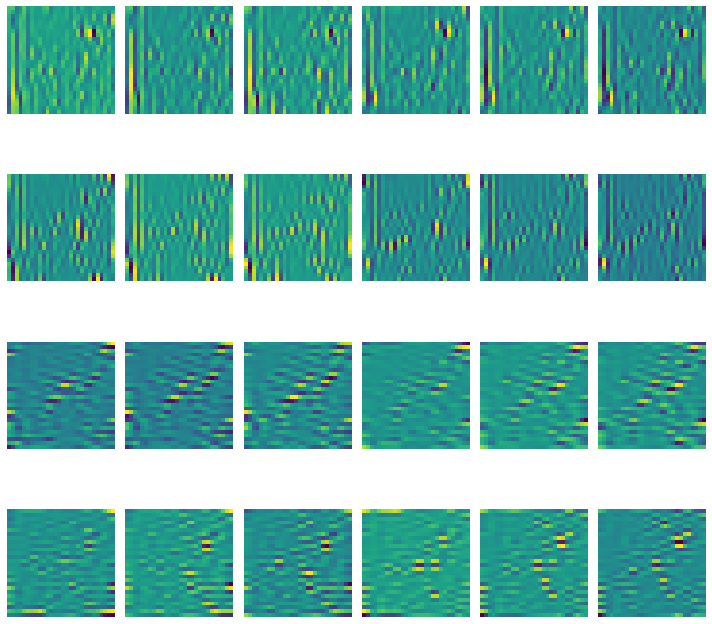

(1, 12, 14, 14)


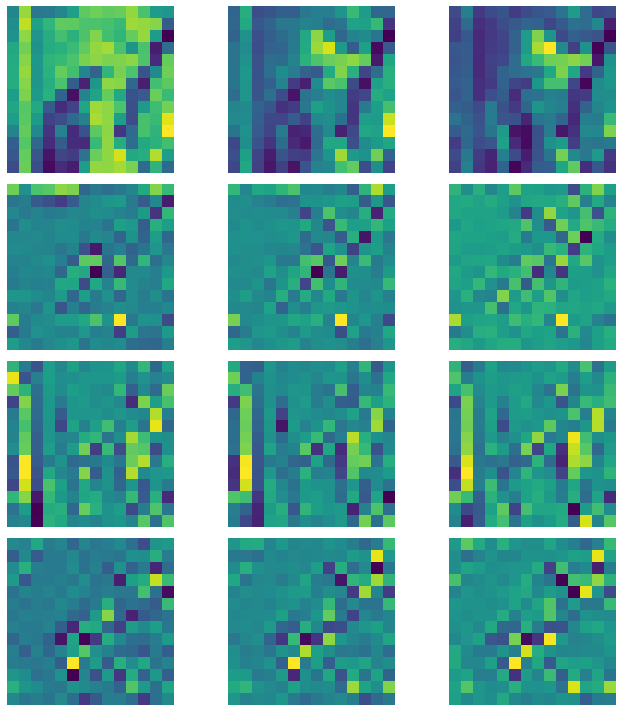

In [6]:
import matplotlib.pyplot as plt


# Collect tensor with same dimension into a dict of list
output = {}
for i in range(len(y)):
    if isinstance(y[i], list):
        for j in range(len(y[i])):
            shape = tuple(y[i][j].shape)
            if shape in output.keys():
                output[shape].append(y[i][j])
            else:
                output[shape] = [y[i][j]]
    else:
        shape = tuple(y[i].shape)
        if shape in output.keys():
            output[shape].append(y[i])
        else:
            output[shape] = [y[i]]

# Concat the list of tensors into single tensor
for k in output.keys():
    output[k] = torch.cat(output[k], dim=1)

    
for k in output.keys():
    print(k)
    idx = 1
    # create figure
    fig = plt.figure(figsize=(10, 10))
    for i in range(output[k].shape[0]):
        for j in range(output[k].shape[1]):
            # print(output[k][i][j].shape)
            fig.add_subplot(4, k[1]//4, idx)
            plt.axis('off')
            plt.imshow(output[k][i][j])
            idx = idx + 1
    plt.tight_layout()
    plt.show()

Note that for this setting, the decomposition produce four levels of decomposition output, each with different dimensions and number of outputs read the original paper for more details: 
- `112x112` = 3 channels * 8 = 24 outputs
- `56x56` = 3 channels * 8 = 24 outputs
- `28x28` = 3 channels * 8 = 24 outputs
- `14x14` = 3 channels * 4 = 12 outputs